In [ ]:
#Create G-J templates from GAIA data crossed with 2Masss

In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
def cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source,s1):
    #Masks data values 
    
    # mask all data that does not have a Qfl value of A
    for i in range(0,len(QFlags)):
        if(QFlags[i][0] == ord("A")):
            Jmag.mask[i] = False
        else:
             Jmag.mask[i] = True
            
    for i in range(0,len(QFlags)):
        if(QFlags[i][2] == ord("A")):
            Kmag.mask[i] = False
        else:
            Kmag.mask[i] = True  
        
    for i in range(0,len(QFlags)):
        if(QFlags[i][1] == ord("A")):
            Hmag.mask[i] = False
        else:
            Hmag.mask[i] = True
    
    #mask all values with dup = 1
    imask = 0
    for i in range(0,len(dup)):
        if (dup[i] > 0.5):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
    for i in range(0,len(dup)):
        if(dup[i] > 0.5):
            print(i,dup[i])
    print("Masked ",imask," rows in which dup is equal to 1")
    
    #remove dupliacte matches
    Test = Source.compressed()
    unique = set()
    Gdups = set()

    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("GAIA Duplicate Source: ",Test[i])
            Gdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Gdups):
                row = t[i]
                idx = row._index
                cols = row._table.columns.values()
                for col in cols:
                    col.mask[i] = True
    print("Finished masking all GAIA duplicates. All sources involved")
    TwoM = t["_2MASS"]
    unique = set()
    Tdups = set()
    Test = TwoM.compressed()
    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("2MASS Duplicate Source: ",Test[i])
            Tdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Tdups):
                print(Source[i],s1[i],Gmag[i],Vmag[i]-Gmag[i],Jmag[i],Kmag[i],TwoM[i])
                
    #masked rows with J-G greater than 5 sigma from mean
    J_G = Jmag-Gmag
    JGmean = np.mean(J_G)
    JGstd = np.std(J_G)
    imask = 0
    for i in range(0,len(J_G)):
        if(abs(J_G[i] - JGmean) > 5*JGstd):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
    print("Masked ",imask," rows based on J-G color > 5 sigma from mean")
    
    return t

In [3]:
def AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag):
    #Calculate distance, and absolute magnitudes
    
    Dist = ma.array([])
    Vmags = ma.array([])
    Bmags = ma.array([])
    Gmags = ma.array([])
    Jmags = ma.array([])
    Hmags = ma.array([])
    Kmags = ma.array([])

    Dist = 1000./plx
    Vmags = Vmag - 5 * np.log10(Dist) + 5
    Bmags = Bmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag -5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    
    return Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags

In [85]:
def ColorClassification(Gmags,Kmags):    
    #split the stars into different categories based on G-K
    
    G_K = Gmags-Kmags
    color = np.ones(len(G_K))*1000
    colors = np.arange(0.25,3,0.25)
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color,colors

In [63]:
def CreateTemplates(color,colors,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags):
    #for each color class, a template is created of the absolute magnitudes of the stars and their color indices
    
    G_K = Gmags-Kmags
    #wavelengths of color bands
    wvl = [420, 477, 1235, 1662, 2159]
    wvl2 = [420, 477, 673,1235, 1662, 2159]
    avg_colors = np.array([])
    err_colors = np.array([])
    stars = np.array([])
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_B_array = ma.array([])
        G_V_array = ma.array([])
        G_J_array = ma.array([])
        G_H_array = ma.array([])
        G_K_array = ma.array([])
        B = ma.array([])
        V = ma.array([])
        G = ma.array([])
        J = ma.array([])
        H = ma.array([])
        K = ma.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(G_K)):
            if (color[i] == c):
                G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
                G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                B = np.append(B,Bmags[i])
                V = np.append(V,Vmags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,Jmags[i])
                H = np.append(H,Hmags[i])
                K = np.append(K,Kmags[i])
                star_count = star_count +1
        #average G-K value
        avg_colors = np.append(avg_colors,np.mean(G_K_array))
        err_colors = np.append(err_colors,np.std(G_K_array))
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.mean(G_B_array), np.mean(G_V_array),\
                     np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
        std_array = [np.std(G_B_array), np.std(G_V_array), \
                     np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
        #absolute SED
        mag_array2 = [np.mean(B), np.mean(V), np.mean(G), \
                      np.mean(J), np.mean(H), np.mean(K)]
        std_array2 = [np.std(B), np.std(V), np.std(G), \
                      np.std(J), np.std(H), np.std(K)]
        #add standard deviation error
        val = np.sqrt(len(G_B_array))
        #std_array = std_array/val
        val2 = np.sqrt(len(B))
        #std_array2 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
        else:
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
    return avg_colors,err_colors,color_mags,color_std,abs_color_mags,abs_color_std

In [50]:
def CreatePlots(colors,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots
    
    wvl = [420, 477, 1235, 1662, 2159]
    wvl2 = [420, 477, 673,1235, 1662, 2159]
    
    #plot average absolute magnitude in each filter for each color 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        ax.errorbar(wvl2, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each color 
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        ax2.errorbar(wvl, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution')
    box2 = ax.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [87]:
def PrintToFile(colors,avg_colors,err_colors,color_mags,color_std):
    
    rows = len(colors)
    colors2 = np.zeros([rows,1])
    avg_colors2 = np.zeros([rows,1])
    err_colors2 = np.zeros([rows,1])
    for i in range(rows):
        colors2[i,0] = colors[i]
        avg_colors2[i,0] = avg_colors[i]
        err_colors2[i,0] = err_colors[i]
    
    arrays=[avg_colors2,err_colors2,color_mags,color_std]

    # Create an array to return to
    FinalTemplate = colors2

    for array in arrays:
        FinalTemplate = np.concatenate([FinalTemplate, array],axis = 1)
        
    columns = 'color,avg_color,err_avg_color,G_B,G_V,G_J,G_H,G_K,G_B_err,G_V_err,G_J_err,G_H_err,G_K_err'
        
    np.savetxt("Template5.csv", FinalTemplate, delimiter=",",header = columns)
    
    return FinalTemplate

In [52]:
from astropy.table import Table
t = Table.read('../dr1_200pc_2Mass.vot', format='votable')

print("The astropy reader loads the data into the following variable names:")
print(t.colnames)
print("\nThe number of stars is " + str(len(t)))

#Rename columns
Source = t["Source"]
Gmag = t["__Gmag_"]
#Using Gmag in place of Vmag and Bmag to calculate Vmags and Bmags
Vmag = t["__Gmag_"]
Bmag = t["__Gmag_"]
Jmag = t["Jmag"]
Hmag = t["Hmag"]
Kmag = t["Kmag"]
QFlags = t["Qfl"]
s1= t["d_arcsec"]
plx = t['Plx']
dup = t['Dup'] 

#I get [IndexError: too many indices for array] if I do not reinput the table t? 

t = cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source,s1)
Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags = AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag)

The astropy reader loads the data into the following variable names:
['d_arcsec', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', '_2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']

The number of stars is 191206


In [86]:
#classify stars according to color and creates templates
color,colors = ColorClassification(Gmags,Kmags)
avg_colors,err_colors,color_mags,color_std,abs_color_mags,abs_color_std = CreateTemplates(color,colors,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags)

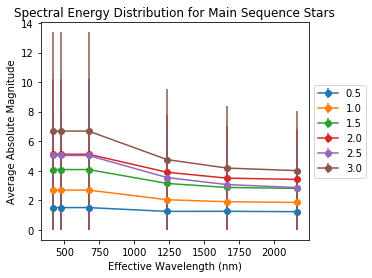

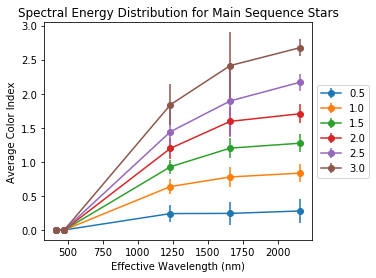

[ 0.5  1.   1.5  2.   2.5  3. ]
[ 0.2778096   0.83354451  1.27265005  1.7050845   2.16733439  2.67427228]
[ 0.17433203  0.13610322  0.1349335   0.13856932  0.12832688  0.12657941]
[[ 0.          0.          0.23989565  0.24253559  0.2778096 ]
 [ 0.          0.          0.63657092  0.77753901  0.83354451]
 [ 0.          0.          0.92735191  1.20062827  1.27265005]
 [ 0.          0.          1.1977241   1.59370879  1.7050845 ]
 [ 0.          0.          1.44233301  1.89368908  2.16733439]
 [ 0.          0.          1.83875903  2.4126506   2.67427228]]
[[ 0.          0.          0.12416791  0.16938361  0.17433203]
 [ 0.          0.          0.11174483  0.14607786  0.13610322]
 [ 0.          0.          0.10556694  0.14577656  0.1349335 ]
 [ 0.          0.          0.15065002  0.20839007  0.13856932]
 [ 0.          0.          0.32954202  0.53487965  0.12832688]
 [ 0.          0.          0.29938619  0.48909329  0.12657941]]
[[ 0.5         0.2778096   0.17433203  0.          0.         

In [32]:
#Template
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

print(colors)
print(avg_colors)
print(err_colors)
print(color_mags)
print(color_std)

finaltemplate = PrintToFile(colors,avg_colors,err_colors,color_mags,color_std)
print(finaltemplate)

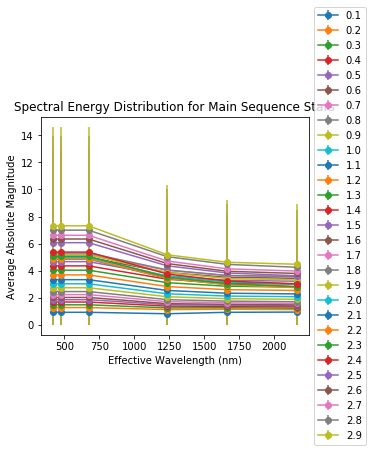

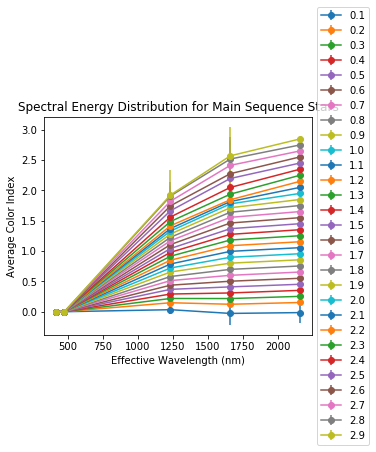

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5
  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9]
[-0.01466285  0.15169084  0.25283938  0.35186091  0.45180921  0.55042757
  0.65320571  0.75308245  0.8548562   0.95457917  1.05448003  1.15183377
  1.25076714  1.34996566  1.44893085  1.54832016  1.64858205  1.74816654
  1.8473206   1.94744439  2.04673827  2.14627776  2.24658804  2.34574533
  2.44751867  2.54840416  2.64690946  2.74558906  2.84445052]
[ 0.17568069  0.02907131  0.02838653  0.02916121  0.02919394  0.02894888
  0.02876013  0.02810145  0.02897906  0.0288202   0.02854263  0.02875569
  0.0286524   0.02877587  0.02932724  0.02867842  0.02896496  0.02876014
  0.02877131  0.0291221   0.02881383  0.02880674  0.02824241  0.02916417
  0.02876496  0.02786099  0.02881356  0.02821602  0.02977727]
[[ 0.          0.          0.03317203 -0.02813761 -0.01466285]
 [ 0.          0.          0.14768119  0.1227802   0.15169084]
 [ 0.          0. 

In [44]:
#Template2
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

print(colors)
print(avg_colors)
print(err_colors)
print(color_mags)
print(color_std)

finaltemplate = PrintToFile(colors,avg_colors,err_colors,color_mags,color_std)
print(finaltemplate)

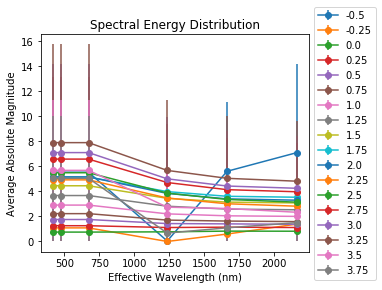

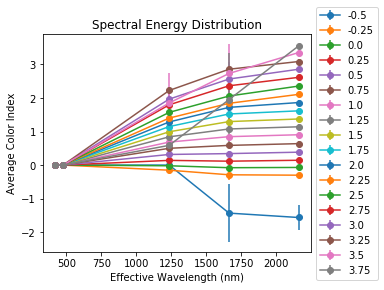

[-0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25
  2.5   2.75  3.    3.25  3.5   3.75]
[-1.56025052 -0.30066665 -0.06990908  0.14386952  0.38428713  0.63862684
  0.90350619  1.14004118  1.37282133  1.61493124  1.86149772  2.10540867
  2.35212376  2.61201136  2.85349064  3.08313048  3.34990905  3.54800018]
[ 0.38243138  0.04577957  0.06093063  0.06885327  0.07111702  0.0724836
  0.06896197  0.06940275  0.07073934  0.07180562  0.07073587  0.07071266
  0.07139368  0.06993489  0.06918657  0.06479085  0.07454271  0.02286186]
[[ 0.          0.          0.         -1.4297502  -1.56025052]
 [ 0.          0.         -0.15222226 -0.28877783 -0.30066665]
 [ 0.          0.         -0.02033938 -0.07795757 -0.06990908]
 [ 0.          0.          0.14015681  0.11632566  0.14386952]
 [ 0.          0.          0.31660809  0.34201219  0.38428713]
 [ 0.          0.          0.4999248   0.5864484   0.63862684]
 [ 0.          0.          0.68561723  0.84612704  0.90350619]
 [ 0.    

In [54]:
#Template3
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

print(colors)
print(avg_colors)
print(err_colors)
print(color_mags)
print(color_std)

finaltemplate = PrintToFile(colors,avg_colors,err_colors,color_mags,color_std)
print(finaltemplate)

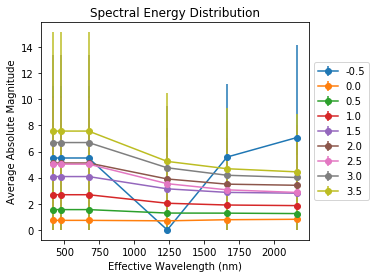

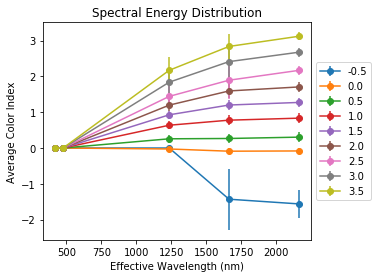

[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]
[-1.56025052 -0.08184481  0.3035578   0.83354451  1.27265005  1.7050845
  2.16733439  2.67427228  3.11981253]
[ 0.38243138  0.0789982   0.1335768   0.13610322  0.1349335   0.13856932
  0.12832688  0.12657941  0.11324794]
[[ 0.          0.          0.         -1.4297502  -1.56025052]
 [ 0.          0.         -0.02716091 -0.08886206 -0.08184481]
 [ 0.          0.          0.25735788  0.26622938  0.3035578 ]
 [ 0.          0.          0.63657092  0.77753901  0.83354451]
 [ 0.          0.          0.92735191  1.20062827  1.27265005]
 [ 0.          0.          1.1977241   1.59370879  1.7050845 ]
 [ 0.          0.          1.44233301  1.89368908  2.16733439]
 [ 0.          0.          1.83875903  2.4126506   2.67427228]
 [ 0.          0.          2.17113754  2.83658755  3.11981253]]
[[ 0.          0.          0.          0.85741613  0.38243138]
 [ 0.          0.          0.06045106  0.0829936   0.0789982 ]
 [ 0.          0.          0.10599648 

In [66]:
#Template4
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

print(colors)
print(avg_colors)
print(err_colors)
print(color_mags)
print(color_std)

finaltemplate = PrintToFile(colors,avg_colors,err_colors,color_mags,color_std)
print(finaltemplate)

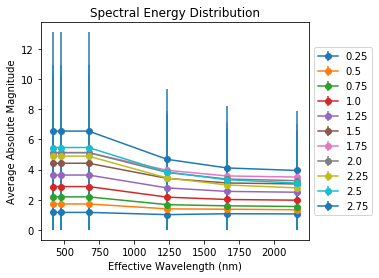

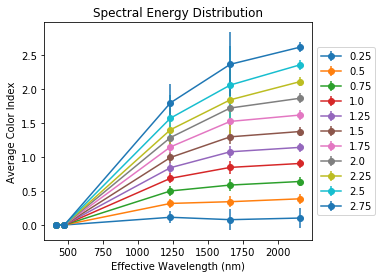

[ 0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75]
[ 0.10158441  0.38428713  0.63862684  0.90350619  1.14004118  1.37282133
  1.61493124  1.86149772  2.10540867  2.35212376  2.61201136]
[ 0.15000429  0.07111702  0.0724836   0.06896197  0.06940275  0.07073934
  0.07180562  0.07073587  0.07071266  0.07139368  0.06993489]
[[ 0.          0.          0.11293304  0.07789725  0.10158441]
 [ 0.          0.          0.31660809  0.34201219  0.38428713]
 [ 0.          0.          0.4999248   0.5864484   0.63862684]
 [ 0.          0.          0.68561723  0.84612704  0.90350619]
 [ 0.          0.          0.84168582  1.07547307  1.14004118]
 [ 0.          0.          0.99206312  1.29516912  1.37282133]
 [ 0.          0.          1.14741496  1.52170138  1.61493124]
 [ 0.          0.          1.28500897  1.71863951  1.86149772]
 [ 0.          0.          1.39956203  1.83918507  2.10540867]
 [ 0.          0.          1.56996369  2.05633169  2.35212376]
 [ 0.          0.          1.795

In [88]:
#Template5
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

print(colors)
print(avg_colors)
print(err_colors)
print(color_mags)
print(color_std)

finaltemplate = PrintToFile(colors,avg_colors,err_colors,color_mags,color_std)
print(finaltemplate)

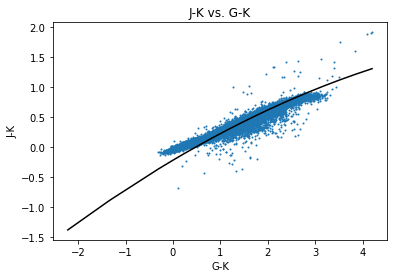

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


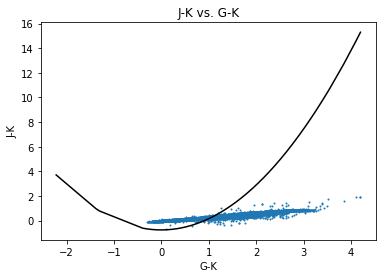

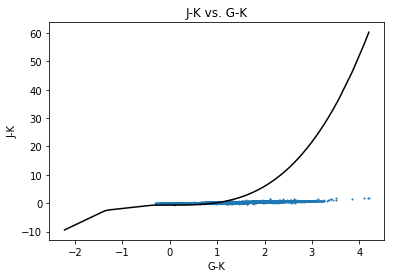

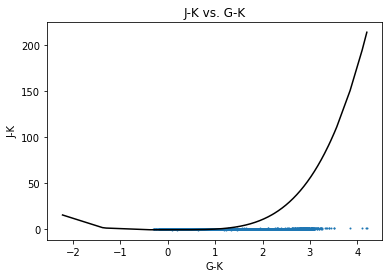

In [61]:
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2
plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = -0.215+0.468*x2-0.025*np.power(x2,2)
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

#polyfit
[a,b,c] = np.polyfit(x,y,2)
[a2,b2,c2,d2] = np.polyfit(x,y,3)
[a3,b3,c3,d3,e3] = np.polyfit(x,y,4)

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a*x2+b*np.power(x2,2) + c
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a2*x2+b2*np.power(x2,2)+c2*np.power(x2,3) + d2
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a3*x2+b3*np.power(x2,2)+c3*np.power(x2,3) + d3*np.power(x2,4) +e3
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

#polyeval

In [ ]:
#Templates

#Template.csv colors = [0.5,1,1.5,2,2.5,3]   
#Template2.csv colors = np.arange(0.1,3,0.1)
#Template3.csv colors = np.arange(-0.5,4,0.25)
#Template4.csv colors = np.arange(-0.5,4,0.5)
#Template5.csv colors = np.arrange(0.25,3,0.25)


(array([  5.70000000e+01,   9.96200000e+03,   1.05404000e+05,
          1.51700000e+03,   7.51000000e+02,   1.65200000e+03,
          6.79300000e+03,   2.58050000e+04,   3.82490000e+04,
          1.01600000e+03]),
 array([ -2.22100067,  -0.66850061,   0.88399944,   2.4364995 ,
          3.98899956,   5.54149961,   7.09399967,   8.64649973,
         10.19899979,  11.75149984,  13.3039999 ]),
 <a list of 10 Patch objects>)

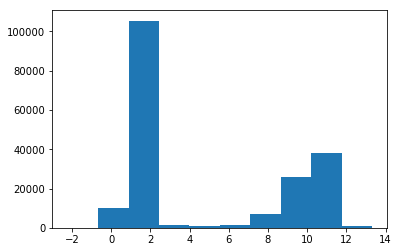

In [47]:
G_K = Gmags-Kmags
plt.hist(G_K2)

In [94]:
#read in templates
from numpy import genfromtxt

#Template1
my_data = genfromtxt('Template.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.5:
        count = count+1
print(count)


[[ 0.5         0.2778096   0.17433203  0.          0.          0.23989565
   0.24253559  0.2778096   0.          0.          0.12416791  0.16938361
   0.17433203]
 [ 1.          0.83354451  0.13610322  0.          0.          0.63657092
   0.77753901  0.83354451  0.          0.          0.11174483  0.14607786
   0.13610322]
 [ 1.5         1.27265005  0.1349335   0.          0.          0.92735191
   1.20062827  1.27265005  0.          0.          0.10556694  0.14577656
   0.1349335 ]
 [ 2.          1.7050845   0.13856932  0.          0.          1.1977241
   1.59370879  1.7050845   0.          0.          0.15065002  0.20839007
   0.13856932]
 [ 2.5         2.16733439  0.12832688  0.          0.          1.44233301
   1.89368908  2.16733439  0.          0.          0.32954202  0.53487965
   0.12832688]
 [ 3.          2.67427228  0.12657941  0.          0.          1.83875903
   2.4126506   2.67427228  0.          0.          0.29938619  0.48909329
   0.12657941]]
6
0


In [95]:
#Template2
my_data = genfromtxt('Template2.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.1:
        count = count+1
print(count)

[[ 0.1        -0.01466285  0.17568069  0.          0.          0.03317203
  -0.02813761 -0.01466285  0.          0.          0.07570449  0.18467759
   0.17568069]
 [ 0.2         0.15169084  0.02907131  0.          0.          0.14768119
   0.1227802   0.15169084  0.          0.          0.0365206   0.04145054
   0.02907131]
 [ 0.3         0.25283938  0.02838653  0.          0.          0.2179522
   0.21669982  0.25283938  0.          0.          0.04311219  0.03995418
   0.02838653]
 [ 0.4         0.35186091  0.02916121  0.          0.          0.2911196
   0.30881224  0.35186091  0.          0.          0.04280327  0.04460851
   0.02916121]
 [ 0.5         0.45180921  0.02919394  0.          0.          0.36826808
   0.40893391  0.45180921  0.          0.          0.04698757  0.044529
   0.02919394]
 [ 0.6         0.55042757  0.02894888  0.          0.          0.43677971
   0.50210564  0.55042757  0.          0.          0.05734803  0.05122477
   0.02894888]
 [ 0.7         0.65320571 

In [96]:
#Template3
my_data = genfromtxt('Template3.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.25:
        count = count+1
print(count)

[[-0.5        -1.56025052  0.38243138  0.          0.          0.
  -1.4297502  -1.56025052  0.          0.          0.          0.85741613
   0.38243138]
 [-0.25       -0.30066665  0.04577957  0.          0.         -0.15222226
  -0.28877783 -0.30066665  0.          0.          0.08467951  0.15229121
   0.04577957]
 [ 0.         -0.06990908  0.06093063  0.          0.         -0.02033938
  -0.07795757 -0.06990908  0.          0.          0.05062499  0.06082518
   0.06093063]
 [ 0.25        0.14386952  0.06885327  0.          0.          0.14015681
   0.11632566  0.14386952  0.          0.          0.06303358  0.07617239
   0.06885327]
 [ 0.5         0.38428713  0.07111702  0.          0.          0.31660809
   0.34201219  0.38428713  0.          0.          0.06672141  0.07782362
   0.07111702]
 [ 0.75        0.63862684  0.0724836   0.          0.          0.4999248
   0.5864484   0.63862684  0.          0.          0.07575589  0.08600825
   0.0724836 ]
 [ 1.          0.90350619  0.06

In [97]:
#Template4
my_data = genfromtxt('Template4.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.5:
        count = count+1
print(count)

[[-0.5        -1.56025052  0.38243138  0.          0.          0.
  -1.4297502  -1.56025052  0.          0.          0.          0.85741613
   0.38243138]
 [ 0.         -0.08184481  0.0789982   0.          0.         -0.02716091
  -0.08886206 -0.08184481  0.          0.          0.06045106  0.0829936
   0.0789982 ]
 [ 0.5         0.3035578   0.1335768   0.          0.          0.25735788
   0.26622938  0.3035578   0.          0.          0.10599648  0.13164823
   0.1335768 ]
 [ 1.          0.83354451  0.13610322  0.          0.          0.63657092
   0.77753901  0.83354451  0.          0.          0.11174483  0.14607786
   0.13610322]
 [ 1.5         1.27265005  0.1349335   0.          0.          0.92735191
   1.20062827  1.27265005  0.          0.          0.10556694  0.14577656
   0.1349335 ]
 [ 2.          1.7050845   0.13856932  0.          0.          1.1977241
   1.59370879  1.7050845   0.          0.          0.15065002  0.20839007
   0.13856932]
 [ 2.5         2.16733439  0.128

In [98]:
#Template5
my_data = genfromtxt('Template5.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.25:
            count = count+1
print(count)

[[ 0.25        0.10158441  0.15000429  0.          0.          0.11293304
   0.07789725  0.10158441  0.          0.          0.08779328  0.15055947
   0.15000429]
 [ 0.5         0.38428713  0.07111702  0.          0.          0.31660809
   0.34201219  0.38428713  0.          0.          0.06672141  0.07782362
   0.07111702]
 [ 0.75        0.63862684  0.0724836   0.          0.          0.4999248
   0.5864484   0.63862684  0.          0.          0.07575589  0.08600825
   0.0724836 ]
 [ 1.          0.90350619  0.06896197  0.          0.          0.68561723
   0.84612704  0.90350619  0.          0.          0.07616704  0.09236799
   0.06896197]
 [ 1.25        1.14004118  0.06940275  0.          0.          0.84168582
   1.07547307  1.14004118  0.          0.          0.07348852  0.09183739
   0.06940275]
 [ 1.5         1.37282133  0.07073934  0.          0.          0.99206312
   1.29516912  1.37282133  0.          0.          0.07584258  0.10080748
   0.07073934]
 [ 1.75        1.614931